From 03_signal_simulation_range.ipynb, we generate out a raw data of a SAR.

In [ ]:
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import math
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interactive, FloatSlider, IntSlider
from scipy.signal import chirp

In [ ]:
def _generate_single_chirp_phase(i, PRI, delay, pulse_width, bandwidth, frequency, sampling_frequency):
    num_time_samples = int((delay + pulse_width) * sampling_frequency) + 1
    t = np.linspace(0, pulse_width, int(pulse_width * sampling_frequency), endpoint=False)
    gamma = bandwidth / pulse_width
    phase_shift = np.exp(1j * (2 * np.pi * frequency * delay + np.pi * gamma * (delay - pulse_width / 2) ** 2))
    base_chirp = np.exp(1j * (2 * np.pi * frequency * t + np.pi * gamma * (t - pulse_width / 2) ** 2))
    return i, delay, base_chirp * phase_shift


def calculate_integration_angle(K_a = 1.2, wavelength = 0.03, azimuth_resolution = 1.0):
    """
    Calculate the satellite integration angle based on the given parameters.
    
    Parameters:
    K_a (float): Broadening Factor of azimuth resoluion to compensate for window filtering, default is 1.2.
    wavelength (float): Wavelength of the signal in meters, default is 0.03.
    azimuth_resolution (float): Desired azimuth resolution in meters, default is 1.0.
    
    Returns:
    float: The calculated integration angle in radians.
    """
    integration_angle = (K_a * wavelength) / (2 * azimuth_resolution)
    return integration_angle


def simulate_sar_raw_data_threaded(num_of_samples, time_result, PRI,
                                pulse_width=1.0, bandwidth=1_000.0, frequency=100_000.0,
                                sampling_frequency=1_000_000):
    """
    Simulates SAR raw data using threading, optimising memory by only storing relevant chirp windows.

    Returns:
    - `raw_data_dict`: Dictionary {i: (start_idx, chirp)}, where i is pulse index.
    - `max_sample`: Total number of time samples needed across all pulses.
    """
    args_list = [
        (i, PRI, time_result[i], pulse_width, bandwidth, frequency, sampling_frequency)
        for i in range(num_of_samples)
    ]

    with ThreadPoolExecutor() as executor:
        results = list(executor.map(lambda args: _generate_single_chirp_phase(*args), args_list))

    raw_data_dict = {}
    max_sample = 0

    for i, delay, chirp in results:
        start_index = int(delay * sampling_frequency)
        raw_data_dict[i] = (start_index, chirp)
        max_sample = max(max_sample, start_index + len(chirp))

    # Create compact array now that we know final dimensions
    raw_data = np.zeros((num_of_samples, max_sample), dtype=np.complex64)

    for i, (start_index, chirp) in raw_data_dict.items():
        end_index = start_index + len(chirp)
        raw_data[i, start_index:end_index] = chirp

    return raw_data


def plot_raw_sar_data(raw_data, sampling_frequency, time_result=None,
                      xlim_microseconds=None, downsample_fast=10, downsample_slow=1, show_delay=True):
    """
    Efficient visualisation of raw SAR data with downsampling.
    
    Parameters:
    - raw_data: 2D array (num_pulses, num_samples)
    - sampling_frequency: Hz
    - time_result: optional list of time delays (seconds)
    - xlim_microseconds: tuple (xmin, xmax) to limit x-axis
    - downsample_fast: downsample factor along fast time
    - downsample_slow: downsample factor along pulse index
    - show_delay: whether to plot slant range time delays
    """

    # Downsample both fast and slow time
    raw_data_ds = raw_data[::downsample_slow, ::downsample_fast].astype(np.float32)
    ds_fs = sampling_frequency / downsample_fast

    num_pulses, num_samples = raw_data_ds.shape
    fast_time_us = np.linspace(0, num_samples / ds_fs * 1e6, num_samples)
    pulse_indices = np.arange(0, raw_data.shape[0], downsample_slow)

    print(f"[INFO] Plotting {num_pulses} pulses, {num_samples} samples per pulse (downsampled)")
    print(f"[INFO] Fast time: {fast_time_us[0]:.2f}–{fast_time_us[-1]:.2f} μs")

    # Heatmap
    plt.figure(figsize=(10, 5))
    plt.imshow(raw_data_ds, aspect='auto',
               extent=[fast_time_us[0], fast_time_us[-1], pulse_indices[-1], pulse_indices[0]],
               cmap='viridis', interpolation='nearest')
    plt.colorbar(label="Amplitude")
    plt.xlabel("Fast Time (μs)")
    plt.ylabel("Pulse Index (Slow Time)")
    plt.title("Simulated Raw SAR Data")

    if xlim_microseconds:
        plt.xlim(xlim_microseconds)

    plt.tight_layout()
    plt.show()

    # Slant Range Delay Plot
    if show_delay and time_result is not None:
        plt.figure(figsize=(8, 3))
        time_us = np.array(time_result) * 1e6
        plt.plot(np.arange(len(time_us)), time_us, linewidth=1)
        plt.xlabel("Pulse Index")
        plt.ylabel("Time Delay (μs)")
        plt.title("Slant Range Time Delays")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


def simulate_time_result(light_speed: float = 3e8, 
                         azimuth_length: float = 100.0, 
                         range_width: float = 100.0, 
                         sensor_speed: float = 100.0, 
                         grazing_angle_deg: float = 40.0,
                         integration_angle_rad: float = 20.0,
                         sensor_height: float = 10000.0,
                         max_capturable_height: float = 0,
                         sampling_frequency: float = 2000,
                         PRF: float = 100,
                         target_x: float = 0,
                         target_y: float = 0,
                         target_z: float = 0):

    # Derived parameters
    grazing_angle_rad = math.radians(grazing_angle_deg)

    h = sensor_height
    v = sensor_speed
    L = azimuth_length
    B = range_width
    C = light_speed
    max_h = max_capturable_height
    x_t, y_t, z_t = target_x, target_y, target_z
    PRI = 1 / PRF

    y_c = h / math.tan(grazing_angle_rad)   # Horizontal distance to the origin of target strip

    delta_max = y_c * math.tan(0.5 * integration_angle_rad)         # Maximum positive distance deviation from APC

    num_of_samples = (2 * abs(delta_max)) / (PRI * v)    # Number of samples to collect

    # Function to calculate distance deviation of current sensor based on sample index
    cal_distance_deviation = lambda idx, vel, PRI, delta_max : (vel * PRI) * int(idx) - delta_max

    # Function to calculate slant distance of the target from the current sensor position
    # cal_target_slant_distance = lambda dist_deviation : math.sqrt((h - abs(z_t))**2 + math.sqrt(abs(dist_deviation - x_t)**2 + (y_c + y_t)**2)**2)   
    cal_target_slant_distance = lambda dist_deviation: math.sqrt(
        (h - z_t)**2 +
        (dist_deviation - x_t)**2 +
        (y_c - y_t)**2
    )   

    # Assume that the distance deviation of sensor when it emit and receive signal is neglible
    cal_time_pulse = lambda distance : (2 *distance) / C

    time_result = []

    for i in range(math.floor(num_of_samples)):
        dist_deviation = cal_distance_deviation(i, v, PRI, delta_max)
        target_slant_distance = cal_target_slant_distance(dist_deviation)   
        time_pulse = cal_time_pulse(target_slant_distance)
        time_result.append(time_pulse)
        if i in [0, math.floor(num_of_samples) // 2]:
            print(f"Sample {i}: Distance Deviation = {dist_deviation:.5f} m, Slant Distance = {target_slant_distance:.2f} m, Time Pulse = {time_pulse:.6f} s, delta_max = {delta_max:.2f} m")

    time_result = np.array(time_result)
    print(time_result[:10]*1e6)

    return time_result

In [ ]:
import time

# Requested resolution
azimuth_resolution = 2.0
sampling_frequency = 1_000_000_000  # Hz
PRF = 500  # Pulse Repetition Frequency in Hz

# Simulate 360MHz X-band SAR
wavelength = 3e8 / 360e6  # X-band SAR wavelength for 360 MHz

integration_angle = calculate_integration_angle(K_a=1.2, wavelength=wavelength, azimuth_resolution=azimuth_resolution)
print(f"Integration angle: {integration_angle:.4f} degrees")

start_time = time.time_ns() * 10**-6  # Convert to milliseconds
time_result = simulate_time_result(
    integration_angle_rad=integration_angle,
    grazing_angle_deg=40.0,
    sensor_speed=7500.0,
    azimuth_length=5_000.0,
    range_width=5_000.0,
    sensor_height=100_000.0,
    PRF=PRF,
    max_capturable_height=0,
    sampling_frequency=sampling_frequency,
    target_x=0_000.0,
    target_y=0_000.0,
    target_z=0.0
)
time_result_time = time.time_ns() * 10**-6  # Convert to milliseconds
print(f"Time taken to simulate time result: {time_result_time - start_time:.2f} milliseconds")
delays_us = np.array(time_result) * 1e6
print(f"Min delay: {delays_us.min():.5f} μs")
print(f"Max delay: {delays_us.max():.5f} μs")
print(f"Total shift: {(delays_us.max() - delays_us.min()):.2f} μs")


raw_data = simulate_sar_raw_data_threaded(
    num_of_samples=len(time_result),
    time_result=time_result,
    PRI=1/PRF,
    pulse_width=0.000005,
    bandwidth=5_000_000.0,
    frequency=3e8 / wavelength, 
    sampling_frequency=sampling_frequency
)

raw_data_time = time.time_ns() * 10**-6  # Convert to milliseconds
print(f"Time taken to simulate raw SAR data: {raw_data_time - time_result_time:.2f} milliseconds")

# Find non-zero energy indices for xlim suggestion
energy = np.abs(raw_data).max(axis=0)
nonzero_indices = np.where(energy > 0.0)[0]

if len(nonzero_indices) > 0:
    start_us = nonzero_indices[0] / sampling_frequency * 1e6
    end_us = nonzero_indices[-1] / sampling_frequency * 1e6
    print(f"Suggested xlim: ({start_us:.1f} μs, {end_us:.1f} μs)")
    plot_raw_sar_data(
        raw_data, 
        sampling_frequency, 
        time_result, 
        xlim_microseconds=(start_us-1, end_us+1), 
        downsample_fast=10,
        downsample_slow=1
        )
else:
    print("No significant signal detected.")

plotting_time = time.time_ns() * 10**-6  # Convert to milliseconds
print(f"Time taken to plot raw SAR data: {plotting_time - raw_data_time:.2f} milliseconds")


In [ ]:
print(3e8/wavelength)
print(3e8/360e6)

In the following, we will now process our SAR raw data signals into a band usable for image formation. First, notice that the above Simulated Raw SAR Data yields a quadratic time shift pulse. We need to shift each of these signals to the start time window in the fast time. That is, we need to shift all the wave points to the left most axis, and we will obtain a vertical signal. As to which wave to centre, we usually pick the centre of our image as the reference (x=0, y=0, z=0).

Sample 0: Distance Deviation = -9954.33305 m, Slant Distance = 155890.52 m, Time Pulse = 0.001039 s, delta_max = 9954.33 m
Sample 663: Distance Deviation = -9.33305 m, Slant Distance = 155572.38 m, Time Pulse = 0.001037 s, delta_max = 9954.33 m
[1039.27014991 1039.26376924 1039.25739815 1039.25103664 1039.24468472
 1039.23834238 1039.23200962 1039.22568645 1039.21937287 1039.21306886]
Sample 0: Distance Deviation = -9954.33305 m, Slant Distance = 155890.52 m, Time Pulse = 0.001039 s, delta_max = 9954.33 m
Sample 663: Distance Deviation = -9.33305 m, Slant Distance = 155572.38 m, Time Pulse = 0.001037 s, delta_max = 9954.33 m
[1039.27014991 1039.26376924 1039.25739815 1039.25103664 1039.24468472
 1039.23834238 1039.23200962 1039.22568645 1039.21937287 1039.21306886]
Suggested xlim: (1037.1 μs, 1044.3 μs)


C:\Users\Keith Kwok\AppData\Local\Temp\ipykernel_12144\240760137.py:78: ComplexWarning: Casting complex values to real discards the imaginary part
  raw_data_ds = raw_data[::downsample_slow, ::downsample_fast].astype(np.float32)


[INFO] Plotting 1327 pulses, 83542 samples per pulse (downsampled)
[INFO] Fast time: 0.00–1044.28 μs


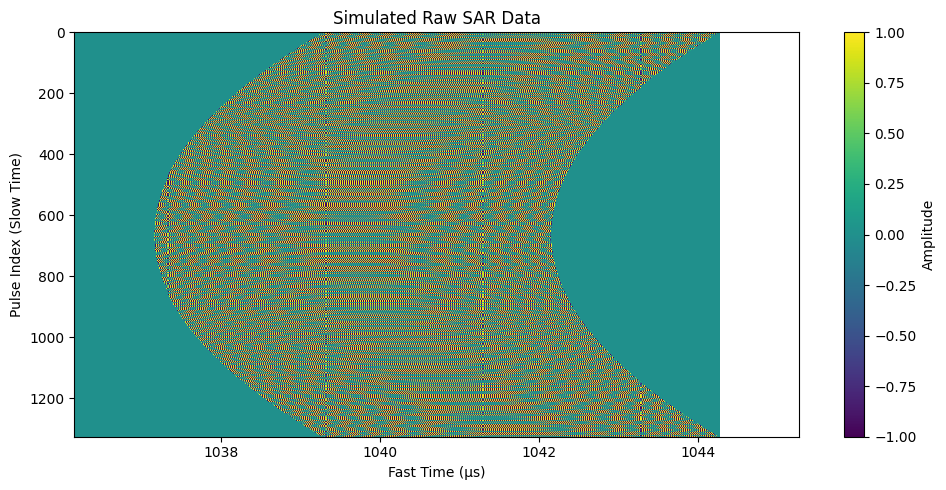

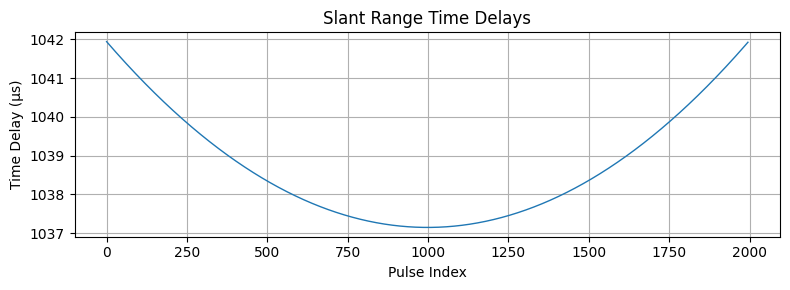

In [116]:
# Requested resolution
azimuth_resolution = 3.0
sampling_frequency = 800_000_000  # Hz
PRF = 500  # Pulse Repetition Frequency in Hz
wavelength = 3e8 / 360e6  # X-band SAR wavelength for 360 MHz

integration_angle = calculate_integration_angle(K_a=1.2, wavelength=wavelength, azimuth_resolution=azimuth_resolution)

grazing_angle_deg=40.0
sensor_speed=7500.0
azimuth_length=5_000.0
range_width=5_000.0
sensor_height=100_000.0
PRF=PRF
max_capturable_height=0
pulse_width=5e-6  # 5 microseconds
bandwidth=5_000_000 
target_x = 0_000.0
target_y = 0_000.0
target_z = 0.0

time_result_ref = simulate_time_result(
    target_x=0,
    target_y=0,
    target_z=0,
    integration_angle_rad=integration_angle,
    grazing_angle_deg=grazing_angle_deg,
    sensor_speed=sensor_speed,
    azimuth_length=azimuth_length,
    range_width=range_width,
    sensor_height=sensor_height,
    PRF=PRF,
    max_capturable_height=max_capturable_height,
    sampling_frequency=sampling_frequency,
)

time_result_target = simulate_time_result(
    integration_angle_rad=integration_angle,
    grazing_angle_deg=grazing_angle_deg,
    sensor_speed=sensor_speed,
    azimuth_length=azimuth_length,
    range_width=range_width,
    sensor_height=sensor_height,
    PRF=PRF,
    max_capturable_height=max_capturable_height,
    sampling_frequency=sampling_frequency,
    target_x=target_x,
    target_y=target_y,
    target_z=target_z
)

# Simulate raw data for the target
raw_data = simulate_sar_raw_data_threaded(
    num_of_samples=len(time_result_target),
    time_result=time_result_target,
    PRI=1/PRF,
    pulse_width=pulse_width,
    bandwidth=bandwidth,
    frequency=3e8/wavelength,
    sampling_frequency=sampling_frequency
)
# Find non-zero energy indices for xlim suggestion (PLOT raw data before alignment)
energy = np.abs(raw_data).max(axis=0)
nonzero_indices = np.where(energy > 0.0)[0]

if len(nonzero_indices) > 0:
    start_us = nonzero_indices[0] / sampling_frequency * 1e6
    end_us = nonzero_indices[-1] / sampling_frequency * 1e6
    print(f"Suggested xlim: ({start_us:.1f} μs, {end_us:.1f} μs)")
    # Plot raw data
    plot_raw_sar_data(
        raw_data,
        sampling_frequency, 
        time_result, 
        xlim_microseconds=(start_us-1, end_us+1), 
        downsample_fast=10,
        downsample_slow=1
        )
else:
    print("No significant signal detected.")




Time result target: [1039.27014991 1039.26376924 1039.25739815 1039.25103664 1039.24468472
 1039.23834238 1039.23200962 1039.22568645 1039.21937287 1039.21306886] μs
Time result reference: [1039.27014991 1039.26376924 1039.25739815 1039.25103664 1039.24468472
 1039.23834238 1039.23200962 1039.22568645 1039.21937287 1039.21306886] μs
Suggested xlim: (0.0 μs, 1044.3 μs)


C:\Users\Keith Kwok\AppData\Local\Temp\ipykernel_12144\240760137.py:78: ComplexWarning: Casting complex values to real discards the imaginary part
  raw_data_ds = raw_data[::downsample_slow, ::downsample_fast].astype(np.float32)


[INFO] Plotting 1327 pulses, 83542 samples per pulse (downsampled)
[INFO] Fast time: 0.00–1044.28 μs


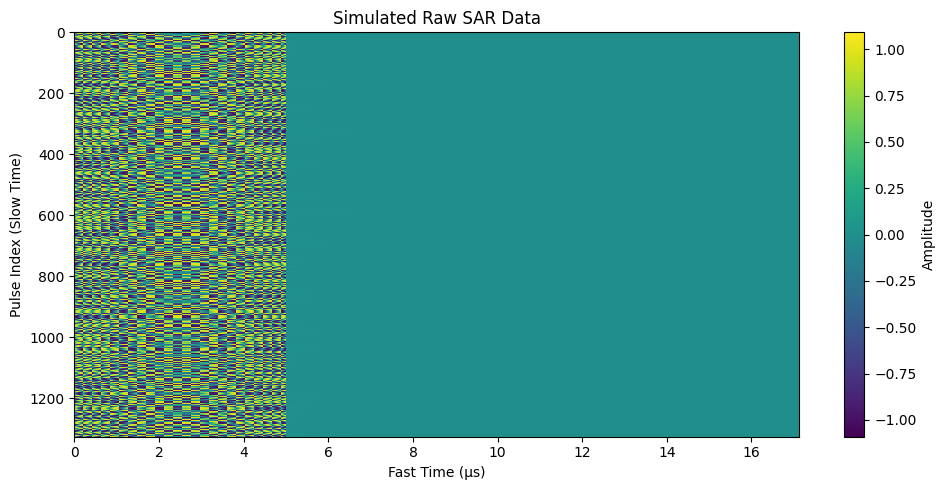

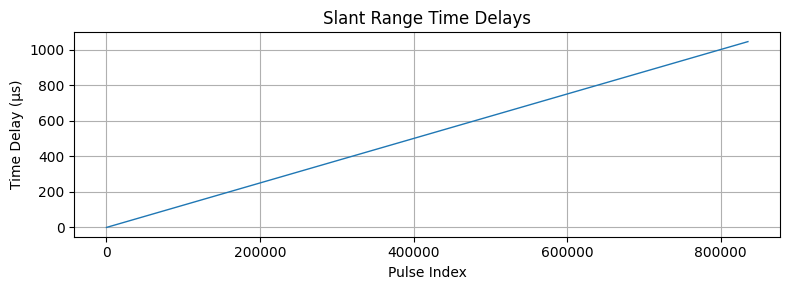

In [117]:
# Get start and end window intervals for alignment
window_us = (end_us + 5) - (start_us - 5)

centre_offset_sec = (window_us / 2) * 1e-6  # Convert to seconds

# Compute time differences relative to reference
print(f"Time result target: {time_result_target[:10] * 1e6} μs")
print(f"Time result reference: {time_result_ref[:10] * 1e6} μs")
time_diff = time_result_target - 2 * time_result_ref

# Create frequency array for fast-time axis
num_fast_time = raw_data.shape[1]
dt = 1 / sampling_frequency
freqs = np.fft.fftfreq(num_fast_time, d=dt)  # Hz

# Apply phase shift to align signal in frequency domain
raw_data_fft = np.fft.fft(raw_data, axis=1)
for i in range(raw_data.shape[0]):
    phase_shift = np.exp(-1j * 2 * np.pi * freqs * time_diff[i])
    raw_data_fft[i, :] *= phase_shift

# Inverse FFT to get aligned signal in time domain
raw_data_delayed = np.fft.ifft(raw_data_fft, axis=1)

# Plot aligned data
energy = np.abs(raw_data_delayed).max(axis=0)
nonzero_indices = np.where(energy > 0.5)[0]

if len(nonzero_indices) > 0:
    start_us = nonzero_indices[0] / sampling_frequency * 1e6
    end_us = nonzero_indices[-1] / sampling_frequency * 1e6
    print(f"Suggested xlim: ({start_us:.1f} μs, {end_us:.1f} μs)")
    plot_raw_sar_data(
        raw_data_delayed,
        sampling_frequency,
        np.arange(num_fast_time) / sampling_frequency,  # fixed fast-time axis
        xlim_microseconds=(start_us, window_us),
        downsample_fast=10,
        downsample_slow=1
    )
else:
    print("No significant signal detected.")

In [118]:
def generate_complex_chirp(pulse_width, amplitude, frequency, bandwidth, sampling_frequency):
    num_samples = int(pulse_width * sampling_frequency)
    t = np.linspace(0, pulse_width, num_samples, endpoint=False)
    gamma = bandwidth / pulse_width
    phase = 2 * np.pi * frequency * t + np.pi * gamma * (t - pulse_width / 2) ** 2

    return amplitude * np.exp(1j * phase)


def matched_filtering_range_real_chirp(raw_data, pulse_width, bandwidth, sampling_frequency, frequency, amplitude=1.0):
    """
    Applies matched filtering to real-valued LFM chirp across fast-time using FFT correlation.
    
    raw_data: 2D array (slow-time × fast-time)
    """
    reference_chirp = generate_complex_chirp(pulse_width, amplitude, frequency, bandwidth=bandwidth, sampling_frequency=sampling_frequency)
    reference_padded = np.zeros(raw_data.shape[1], dtype=np.complex64)
    reference_padded[:len(reference_chirp)] = reference_chirp

    reference_fft = np.fft.fft(reference_padded)

    # FFT of raw data 
    raw_data_fft = np.fft.fft(raw_data, axis=1)

    # Multiply in frequency domain (correlation)
    matched_filtered_fft = raw_data_fft * np.conj(reference_fft)

    compressed_data = np.fft.ifft(matched_filtered_fft, axis=1)

    # PLOT the frequency curves
    # Set fast-time length large enough to hold full chirp
    num_fast_time = 8192
    reference_padded = np.zeros(num_fast_time, dtype=np.complex64)
    reference_padded[:len(reference_chirp)] = reference_chirp

    # FFT of reference chirp
    reference_fft = np.fft.fft(reference_padded)
    reference_fft_db = 20 * np.log10(np.abs(np.fft.fftshift(reference_fft)) + 1e-12)

    # Simulate raw data (single chirp return at known location)
    num_slow_time = 256
    raw_data = np.zeros((num_slow_time, num_fast_time), dtype=np.complex64)
    target_index = 1500
    raw_data[:, target_index:target_index+len(reference_chirp)] += reference_chirp

    # FFT of one row (example: row 0)
    raw_data_fft = np.fft.fft(raw_data[0])
    raw_data_fft_db = 20 * np.log10(np.abs(np.fft.fftshift(raw_data_fft)) + 1e-12)

    # Frequency axis in MHz
    freq_axis = np.fft.fftshift(np.fft.fftfreq(num_fast_time, d=1/sampling_frequency)) / 1e6

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(freq_axis, reference_fft_db, label='Reference Chirp FFT')
    plt.plot(freq_axis, raw_data_fft_db, label='Raw Data FFT', linestyle='--')
    plt.xlabel("Frequency (MHz)")
    plt.ylabel("Magnitude (dB)")
    plt.title("Frequency Domain: Reference Chirp vs Raw Data")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Return real part only (since input and reference were real)
    return compressed_data



def plot_compressed_data_db(data, sampling_frequency, xlim_microseconds=None, downsample_fast=10, downsample_slow=1):
    """
    Plots SAR raw or compressed data in log scale, with ifftshift applied along fast-time axis.
    """
    # Apply inverse FFT shift to fast-time axis
    data_shifted = np.fft.ifftshift(data, axes=1)

    log_magnitude = 20 * np.log10(np.abs(data_shifted) + 1e-12)  # avoid log(0)

    # Fast time axis in μs (natural ordering from 0 to duration)
    num_fast_samples = data.shape[1]
    fast_time = np.arange(num_fast_samples) / sampling_frequency * 1e6  # in μs

    plt.figure(figsize=(12, 6))
    extent = [
        fast_time[0], fast_time[-1],        # x-axis in μs
        0, data.shape[0]                    # y-axis: slow time index
    ]
    plt.imshow(log_magnitude[::downsample_slow, ::downsample_fast],
               aspect='auto',
               extent=extent,
               cmap='viridis',
               origin='lower')
    if xlim_microseconds:
        plt.xlim(*xlim_microseconds)
    plt.xlabel("Fast Time (μs)")
    plt.ylabel("Slow Time Index")
    plt.title("Range-Compressed SAR Data (dB)")
    plt.colorbar(label='Magnitude (dB)')
    plt.tight_layout()
    plt.show()




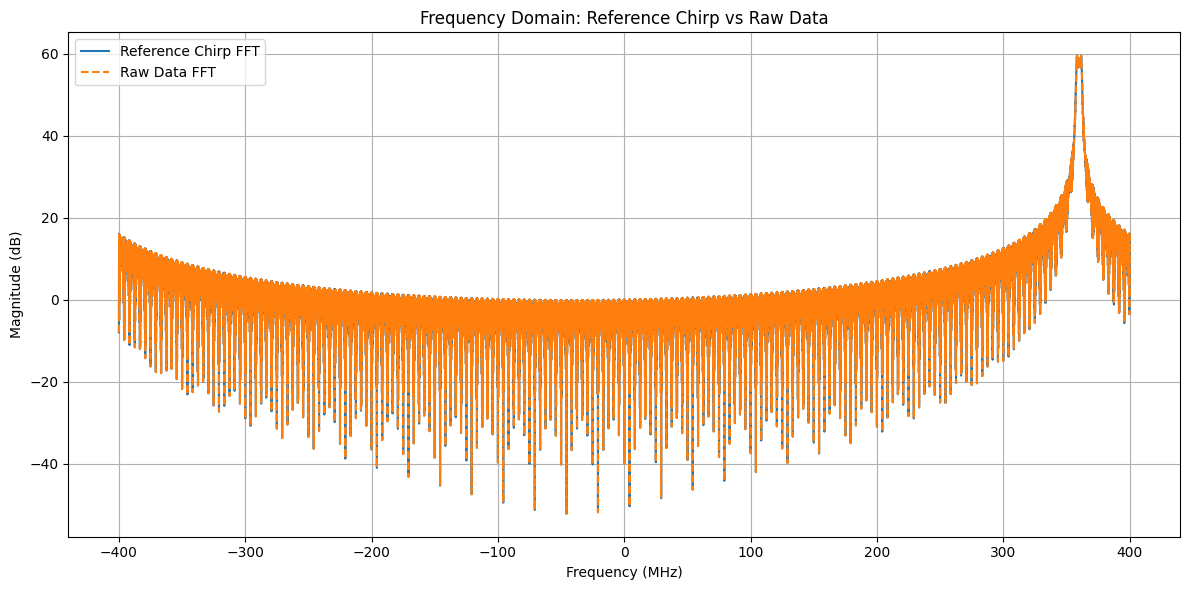

In [119]:
compressed_data = matched_filtering_range_real_chirp(
    raw_data=raw_data_delayed,
    pulse_width=pulse_width,
    bandwidth=bandwidth,
    sampling_frequency=sampling_frequency,
    frequency=3e8 / wavelength,  # centre frequency
    amplitude=1.0
)

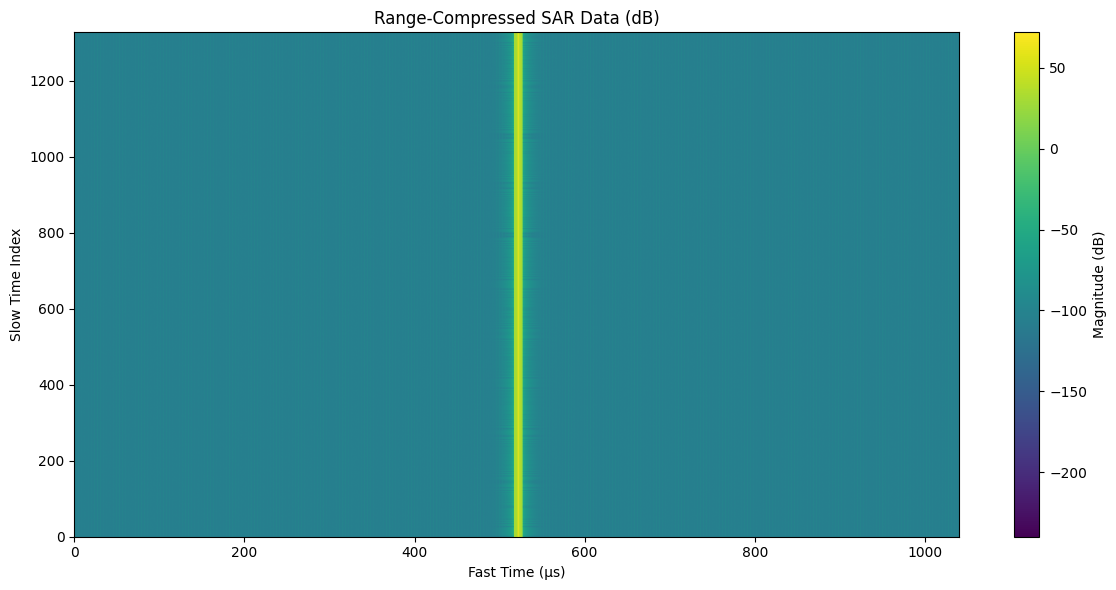

In [126]:
plot_compressed_data_db(
    compressed_data,
    sampling_frequency=sampling_frequency,
    xlim_microseconds=(0, 1040),  
    downsample_fast=5
)


In [122]:
def plot_phase_vs_azimuth(data, sampling_frequency, fast_time_index=None, fast_time_us=None):
    """
    Plots the unwrapped phase of the SAR signal at a given fast-time index or fast-time in microseconds.

    Parameters:
    - data: 2D complex SAR array (azimuth × fast time)
    - sampling_frequency: Hz
    - fast_time_index: Index into the fast-time axis (optional)
    - fast_time_us: Fast time (in μs) to be converted to index (optional)
    """
    if fast_time_index is None and fast_time_us is None:
        raise ValueError("You must provide either fast_time_index or fast_time_us.")

    if fast_time_us is not None:
        fast_time_index = int((fast_time_us * 1e-6) * sampling_frequency)

    if fast_time_index >= data.shape[1]:
        raise IndexError("fast_time_index out of bounds.")

    phase = np.unwrap(np.angle(data[:, fast_time_index]))

    plt.figure(figsize=(8, 5))
    plt.plot(phase)
    plt.xlabel("Azimuth Index (Pulse Number)")
    plt.ylabel("Unwrapped Phase (radians)")
    plt.title(f"Phase vs Azimuth at Fast Time Index {fast_time_index}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

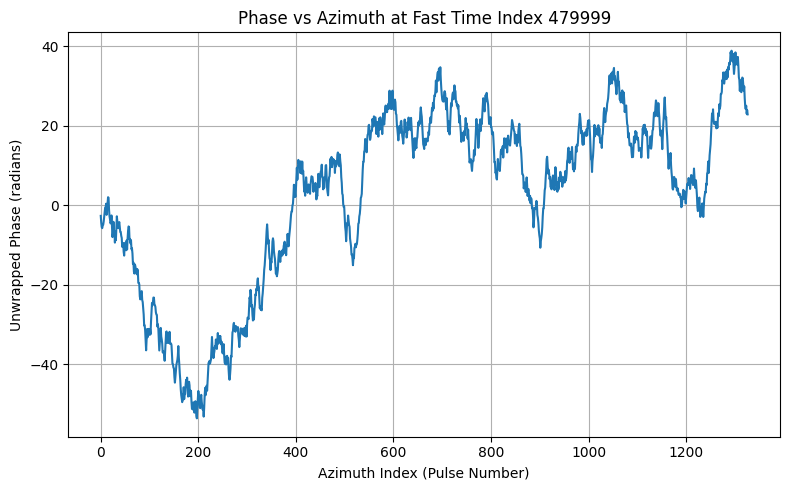

In [130]:
plot_phase_vs_azimuth(compressed_data, sampling_frequency, fast_time_us=600)

In [128]:
import scipy.signal as signal
import numpy as np

def azimuth_compression(data):
    """
    Applies FFT and IFFT along azimuth (slow-time), with phase detrending before compression.
    """
    # FFT along azimuth
    data_fft = np.fft.fft(data, axis=0)

    # Detrend phase across azimuth for each range bin
    for col in range(data_fft.shape[1]):
        spectrum = data_fft[:, col]
        phase = np.unwrap(np.angle(spectrum))
        phase_detrended = signal.detrend(phase)
        data_fft[:, col] = np.abs(spectrum) * np.exp(1j * phase_detrended)

    # IFFT back to azimuth time domain
    focused_data = np.fft.ifft(data_fft, axis=0)
    return data_fft



def plot_final_focused_result(data, sampling_frequency, title="Focused SAR Image (Range + Azimuth)",
                              downsample_fast=1, downsample_slow=1):
    """
    Plots the focused SAR image in log scale with optional downsampling.

    Parameters:
    - data: 2D array of complex SAR data (azimuth x fast-time)
    - sampling_frequency: Sampling frequency in Hz
    - title: Plot title
    - downsample_fast: Factor to downsample fast-time axis
    - downsample_slow: Factor to downsample slow-time axis
    """
    # Apply inverse FFT shift to fast-time axis
    data_shifted = np.fft.ifftshift(data, axes=1)

    # Compute magnitude in dB
    log_magnitude = 20 * np.log10(np.abs(data_shifted) / np.max(np.abs(data_shifted)) + 1e-12)

    # Create time axis in microseconds
    num_fast = data.shape[1]
    fast_time_axis = np.arange(num_fast) / sampling_frequency * 1e6  # μs

    # Apply downsampling
    log_magnitude_ds = log_magnitude[::downsample_slow, ::downsample_fast]
    fast_time_axis_ds = fast_time_axis[::downsample_fast]
    azimuth_axis_ds = np.arange(data.shape[0])[::downsample_slow]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.imshow(log_magnitude_ds,
               aspect='auto',
               extent=[fast_time_axis_ds[0], fast_time_axis_ds[-1], azimuth_axis_ds[0], azimuth_axis_ds[-1]],
               origin='lower',
               cmap='viridis')
    plt.xlabel("Fast Time (μs)")
    plt.ylabel("Azimuth Index")
    plt.title(title)
    plt.colorbar(label="Magnitude (dB)")
    plt.tight_layout()
    plt.show()



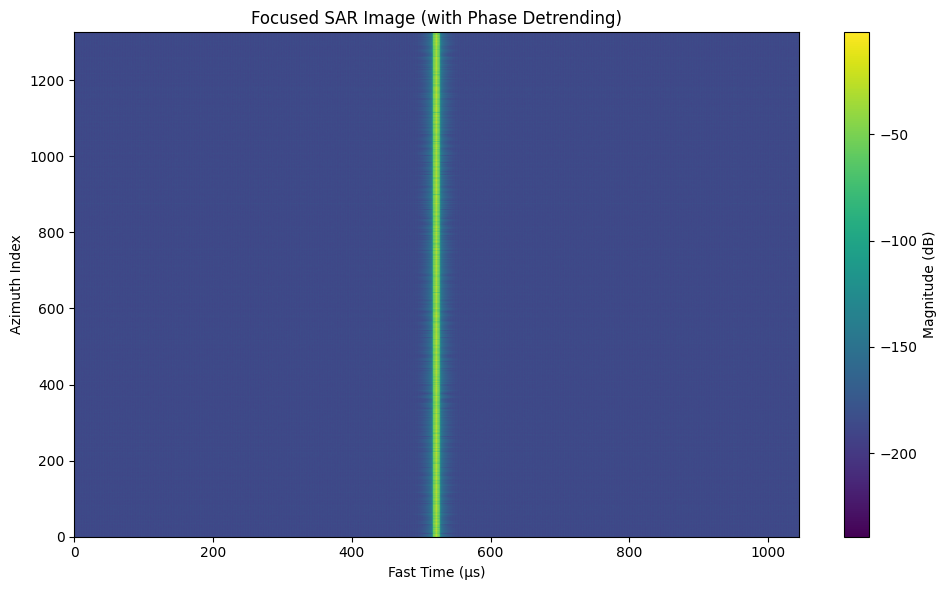

In [129]:
# Perform azimuth compression with phase correction
azimuth_focused = azimuth_compression(compressed_data)

# Plot final SAR image
plot_final_focused_result(azimuth_focused, sampling_frequency, title="Focused SAR Image (with Phase Detrending)", downsample_fast=10, downsample_slow=2)


## Performing Matched filtering before range resolution (shifting)

In [ ]:
def apply_phase_alignment(compressed_data, time_result_target, time_result_ref, sampling_frequency):
    """
    Applies phase-based time alignment to compressed SAR data.
    
    compressed_data: 2D ndarray (azimuth × fast-time)
    time_result_target, time_result_ref: time delays (in seconds)
    sampling_frequency: float (Hz)
    """
    num_fast_time = compressed_data.shape[1]
    freqs = np.fft.fftfreq(num_fast_time, d=1 / sampling_frequency)
    
    delta_t = time_result_target - time_result_ref  # per azimuth line
    data_fft = np.fft.fft(compressed_data, axis=1)

    for i in range(compressed_data.shape[0]):
        phase_shift = np.exp(-1j * 2 * np.pi * freqs * delta_t[i])
        data_fft[i, :] *= phase_shift

    aligned_data = np.fft.ifft(data_fft, axis=1)
    return aligned_data


In [ ]:
print(freqs)
plt.figure(figsize=(10, 5))
plt.plot(freqs)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Frequency Spectrum of Compressed Data (Azimuth Line 0)")
plt.grid(True)


In [ ]:
# Matched filtering
compressed_data = matched_filtering_range_real_chirp(
    raw_data,
    pulse_width,
    bandwidth,
    sampling_frequency,
    frequency=3e8 / wavelength
)

time_diff = time_result_target - 2 * time_result_ref

# Phase shift to align range
print(freqs)
compressed_fft = np.fft.fft(compressed_data, axis=1)
for i in range(compressed_data.shape[0]):
    shift = np.exp(-1j * 2 * np.pi * freqs * time_diff[i])
    compressed_fft[i, :] *= shift
aligned_data = np.fft.ifft(compressed_fft, axis=1)


In [ ]:
plot_raw_sar_data(
    raw_data=raw_data,
    sampling_frequency=sampling_frequency,
    time_result=time_result_target,
    xlim_microseconds=(1035, 1050),
    downsample_fast=10,
    downsample_slow=1,
)

In [ ]:
plot_raw_sar_data(
        np.abs(compressed_data), 
        sampling_frequency, 
        time_result_target, 
        xlim_microseconds=(1035, 1040), 
        downsample_fast=10,
        downsample_slow=1
        )

In [ ]:
# First pulse of compressed data
compressed_data_first_pulse = compressed_data[0, :]
x = np.fft.fft(compressed_data_first_pulse)
x = np.fft.ifftshift(x)
#plot first pulse in frequency domain
plt.figure(figsize=(10, 5))
plt.plot(np.fft.fftfreq(len(x), d=1/sampling_frequency), 20 * np.log10(np.abs(x) + 1e-12))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("Frequency Spectrum of First Pulse")
plt.xlim(0, sampling_frequency/2)  # Limit to Nyquist frequency
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
plot_raw_sar_data(
        np.abs(aligned_data), 
        sampling_frequency, 
        time_result_target + time_diff, 
        xlim_microseconds=(0, window_us), 
        downsample_fast=10,
        downsample_slow=1
        )

In [ ]:
plot_phase_vs_azimuth(aligned_data, sampling_frequency, fast_time_us=0)

In [ ]:
# Perform azimuth compression with phase correction
azimuth_focused = azimuth_compression(aligned_data)

In [ ]:
print(f"Azimuth focused shape: {azimuth_focused.shape}")
print(f"Azimuth focused dtype: {azimuth_focused.dtype}")
print(f"Azimuth focused max value: {np.max(np.abs(azimuth_focused))}")

In [ ]:
# Plot final SAR image
plot_final_focused_result(azimuth_focused, sampling_frequency, title="Focused SAR Image (with Phase Detrending)", downsample_fast=10, downsample_slow=2)